In [1]:
%cd C:\Users\anna-\Promotion\ML_Hackathon_2020\spatial-tools

C:\Users\anna-\Promotion\ML_Hackathon_2020\spatial-tools


In [2]:
import os
import scanpy as sc
import pandas as pd
import networkx as nx

from spatial_tools import read_seqfish

%load_ext autoreload
%autoreload 2
#%load_ext lab_black

BASE_PATH = ''

In [3]:
adata_ob = read_seqfish(BASE_PATH, "ob")
adata_svz = read_seqfish(BASE_PATH, "svz")
adata_ob

C:\Users\anna-\Anaconda3\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2050 × 10000
    obs: 'index', 'louvain', 'Field of View', 'Cell ID', 'X', 'Y'
    obsm: 'spatial'

Trying to set attribute `.uns` of view, copying.


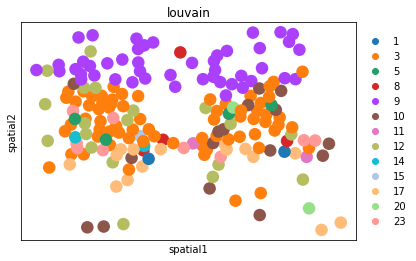

In [4]:
sc.pl.embedding(
    adata_ob[adata_ob.obs["Field of View"] == 6], basis="spatial", color="louvain"
)

In [5]:
louvain_classes = adata_ob.obs['louvain'].unique().tolist()

In [7]:
sc.pp.neighbors(adata_ob)

         Falling back to preprocessing with `sc.pp.pca` and default params.


C:\Users\anna-\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)
C:\Users\anna-\Anaconda3\lib\site-packages\scanpy\neighbors\__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
C:\Users\anna-\Anaconda3\lib\site-packages\scanpy\neighbors\__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


In [8]:
sc.tl.umap(adata_ob)

C:\Users\anna-\Anaconda3\lib\site-packages\scanpy\tools\_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


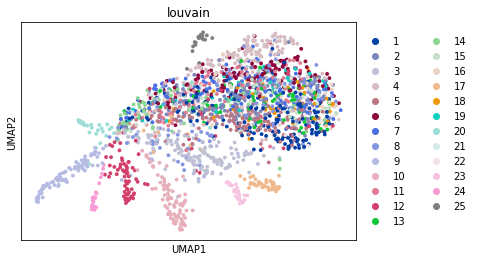

In [9]:
sc.pl.umap(adata_ob, color='louvain')

In [10]:
adata_connectivities = adata_ob.obsp['connectivities']

In [11]:
networkx_graph = nx.from_scipy_sparse_matrix(adata_connectivities)

In [29]:
degree_centrality = []
betweenness_centrality = []
eigenvector_centrality = []
for c in louvain_classes:
    class_node_indices = adata_ob[adata_ob.obs['louvain'] == c].obs['index'].tolist()
    centrality = nx.algorithms.centrality.group_degree_centrality(networkx_graph, class_node_indices)
    subgraph = networkx_graph.subgraph(class_node_indices)
    #eigenvector = nx.algorithms.centrality.eigenvector_centrality(subgraph)
    betweenness = nx.algorithms.centrality.betweenness_centrality(subgraph)
    degree_centrality.append(centrality)
    betweenness_centrality.append(sum(betweenness.values()))
    #eigenvector_centrality.append(eigenvector)

In [30]:
df = pd.DataFrame(list(zip(louvain_classes, degree_centrality, betweenness_centrality)), 
               columns =['cluster', 'degree\ncentrality', 'betweenness\ncentrality']) 

In [31]:
df

,cluster,degree\ncentrality,betweenness\ncentrality
0,10,0.040816,1.366445
1,3,0.250526,1.779975
2,1,0.542001,2.905276
3,15,0.392767,0.659407
4,5,0.469848,2.315053
5,25,0.069034,0.461905
6,17,0.079000,1.061224
7,11,0.380662,2.403041
8,22,0.209383,0.025362
9,2,0.506349,2.720404


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

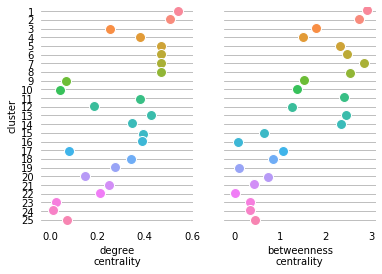

In [34]:
#values = [ "degree\ncentrality",  "betweenness\ncentrality", "eigenvector\ncentrality"]
values = [ "degree\ncentrality", "betweenness\ncentrality"]
for i, value in zip([1, 2], values):
    plt.subplot(1, 2,  i)
    ax = sns.stripplot(data=df, y="cluster", x=value,
                  size=10, orient="h",linewidth=1, edgecolor="w")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.grid(True)
    ax.tick_params(bottom=False,
                    left=False,
                    right=False,
                    top=False)
    if i > 1:
        plt.ylabel(None)
        ax.tick_params(labelleft=False)